# 第 7 章第 2 节-使用决策树预测泰坦尼克号幸存者

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
def read_dataset(fname):
    # 指定第一列作为行索引
    data = pd.read_csv(fname, index_col=0)
    # 丢弃无用的数据
    data.drop(['Name', 'Ticket', 'Cabin'], axis=1, inplace=True)
    # 处理性别数据
    data['Sex'] = (data['Sex'] == 'male').astype('int')
    # 处理登船港口数据
    labels = data['Embarked'].unique().tolist()
    data['Embarked'] = data['Embarked'].apply(lambda n: labels.index(n))
    # 处理缺失数据
    data = data.fillna(0)
    return data


train = read_dataset('./datasets/titanic/train.csv')

In [3]:
train.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
PassengerId,,,,,,,,
1,0,3,1,22.0,1,0,7.2500,0
2,1,1,0,38.0,1,0,71.2833,1
3,1,3,0,26.0,0,0,7.9250,0
4,1,1,0,35.0,1,0,53.1000,0
5,0,3,1,35.0,0,0,8.0500,0


决策树模型不用做特征归一化。

In [14]:
X = train.drop(['Survived'], axis=1).values
y = train['Survived'].values

In [15]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=666)

In [16]:
X_train.shape

(712, 7)

In [17]:
X_test.shape

(179, 7)

In [18]:
from sklearn.tree import DecisionTreeClassifier

clf = DecisionTreeClassifier()
clf.fit(X_train, y_train)
train_score = clf.score(X_train, y_train)
test_score = clf.score(X_test, y_test)

In [19]:
train_score

0.9817415730337079

In [20]:
test_score

0.776536312849162

使用默认的决策树模型已经过拟合了。

## 试试一些集成的树模型

In [43]:
def ensemble_tree_model(clf):
    clf.fit(X_train, y_train)
    train_score = clf.score(X_train, y_train)
    test_score = clf.score(X_test, y_test)
    print('train_score: {:.4f}'.format(train_score))
    print('test_score : {:.4f}'.format(test_score))

In [44]:
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier(n_estimators=500)
ensemble_tree_model(rfc)

train_score: 0.9817
test_score : 0.8603


In [45]:
from xgboost import XGBClassifier

xgbc = XGBClassifier()
ensemble_tree_model(xgbc)

train_score: 0.8708
test_score : 0.8101


In [46]:
from sklearn.ensemble import AdaBoostClassifier

abc = AdaBoostClassifier()
ensemble_tree_model(abc)

train_score: 0.8357
test_score : 0.8101


In [47]:
from sklearn.ensemble import GradientBoostingClassifier

gbc = GradientBoostingClassifier()
ensemble_tree_model(gbc)

train_score: 0.8919
test_score : 0.8268


随机森林的泛化性能更好些。

## 绘图

In [6]:
from sklearn.tree import export_graphviz

with open("titanic.dot", 'w') as f:
    f = export_graphviz(clf, out_file=f)

# 1. 在电脑上安装 graphviz
# 2. 运行 `dot -Tpng titanic.dot -o titanic.png`
# 3. 在当前目录查看生成的决策树 titanic.png

## 超参数选择 

+ max_depth。

best param: 9; best score: 0.8324022346368715


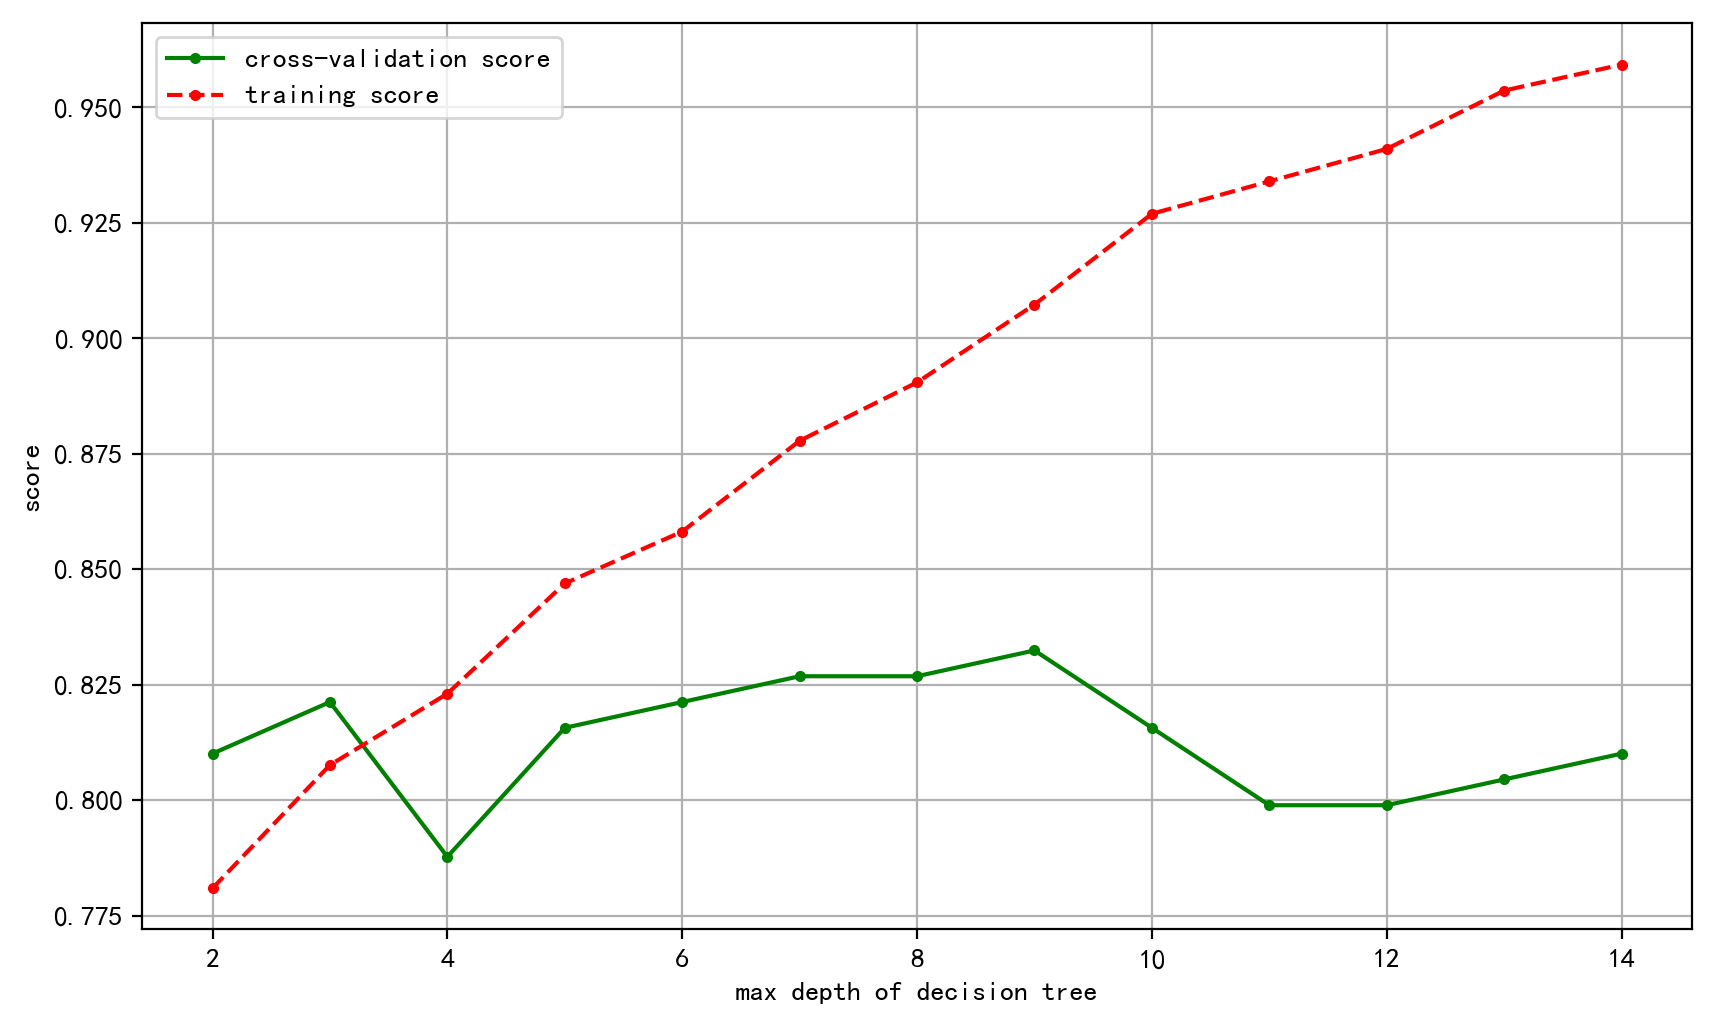

In [7]:
def cv_score(d):
    clf = DecisionTreeClassifier(max_depth=d)
    clf.fit(X_train, y_train)
    tr_score = clf.score(X_train, y_train)
    cv_score = clf.score(X_test, y_test)
    return (tr_score, cv_score)


depths = range(2, 15)
scores = [cv_score(d) for d in depths]
tr_scores = [s[0] for s in scores]
cv_scores = [s[1] for s in scores]

best_score_index = np.argmax(cv_scores)
best_score = cv_scores[best_score_index]
best_param = depths[best_score_index]
print('best param: {0}; best score: {1}'.format(best_param, best_score))

plt.figure(figsize=(10, 6), dpi=100)
plt.grid()
plt.xlabel('max depth of decision tree')
plt.ylabel('score')
plt.plot(depths, cv_scores, '.g-', label='cross-validation score')
plt.plot(depths, tr_scores, '.r--', label='training score')
plt.legend()
plt.show()

在验证数据集上表现最好的参数值是 $9$。

+ min_impurity_decrease。

best param: 0.01020408163265306; best score: 0.8212290502793296


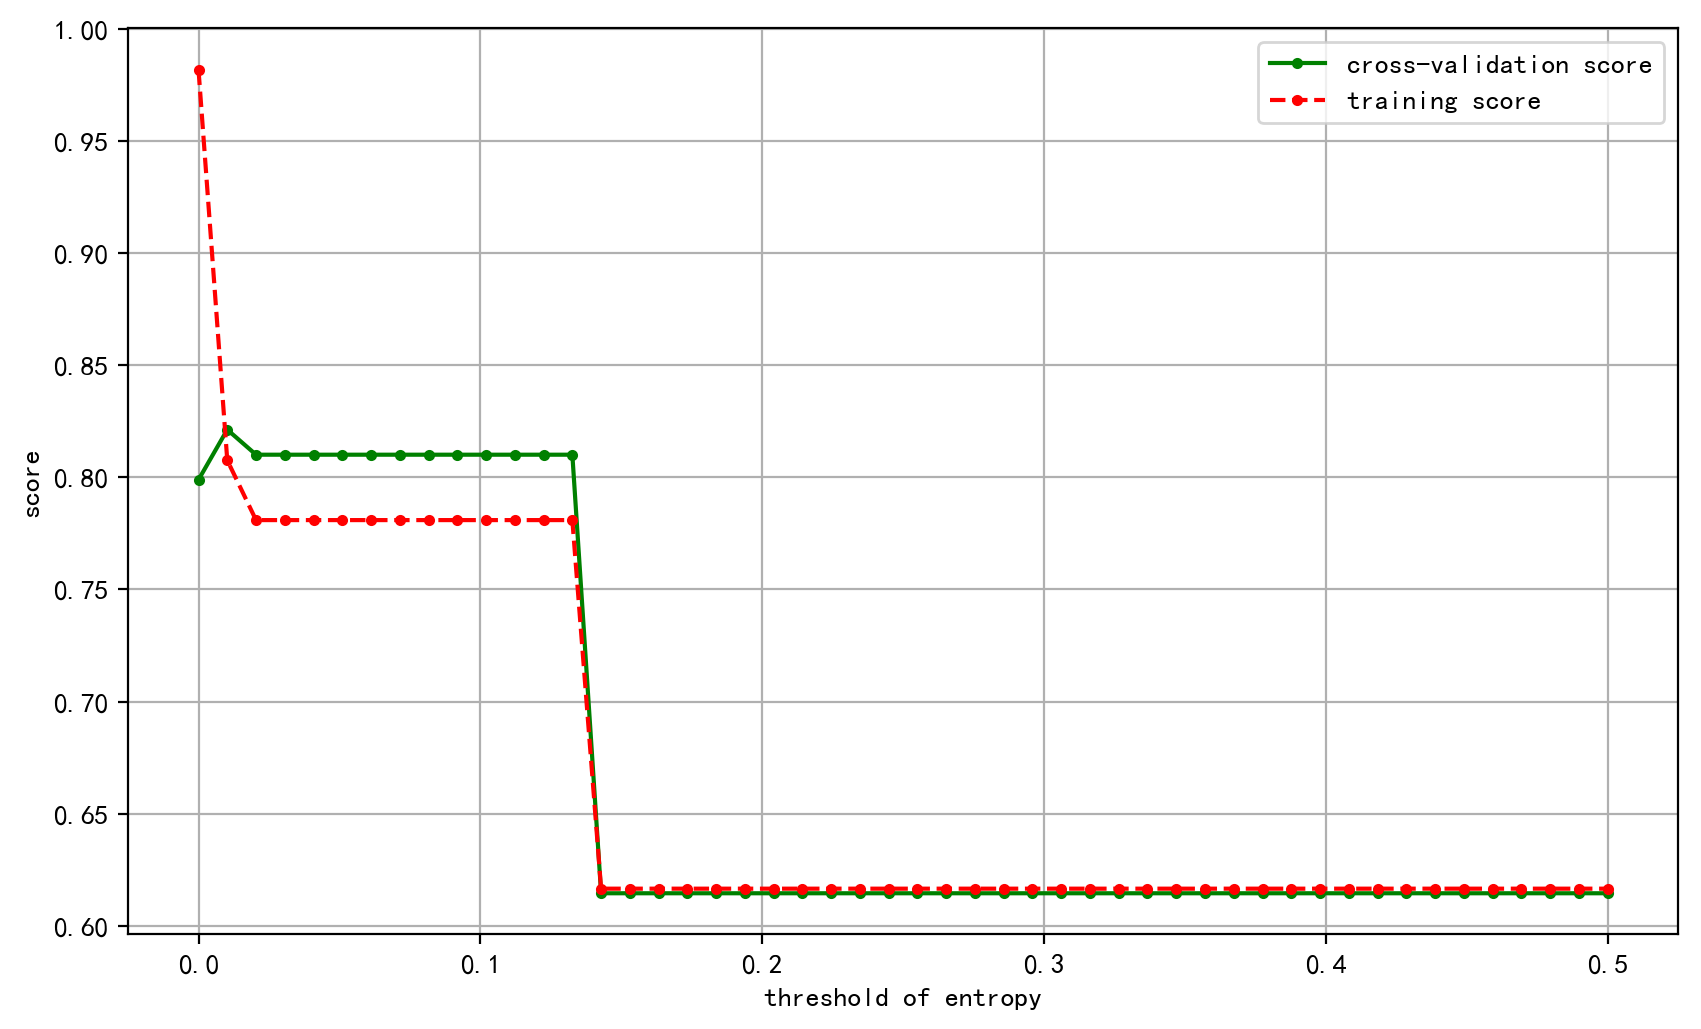

In [8]:
# 训练模型，并计算评分
def cv_score(val):
    clf = DecisionTreeClassifier(criterion='gini', min_impurity_decrease=val)
    clf.fit(X_train, y_train)
    tr_score = clf.score(X_train, y_train)
    cv_score = clf.score(X_test, y_test)
    return (tr_score, cv_score)


# 指定参数范围，分别训练模型，并计算评分
values = np.linspace(0, 0.5, 50)
scores = [cv_score(v) for v in values]
tr_scores = [s[0] for s in scores]
cv_scores = [s[1] for s in scores]

# 找出评分最高的模型参数
best_score_index = np.argmax(cv_scores)
best_score = cv_scores[best_score_index]
best_param = values[best_score_index]
print('best param: {0}; best score: {1}'.format(best_param, best_score))

# 画出模型参数与模型评分的关系
plt.figure(figsize=(10, 6), dpi=100)
plt.grid()
plt.xlabel('threshold of entropy')
plt.ylabel('score')
plt.plot(values, cv_scores, '.g-', label='cross-validation score')
plt.plot(values, tr_scores, '.r--', label='training score')
plt.legend()
plt.show()

## 使用 GridSearchCV

In [48]:
def plot_curve(train_sizes, cv_results, xlabel):
    train_scores_mean = cv_results['mean_train_score']
    train_scores_std = cv_results['std_train_score']
    test_scores_mean = cv_results['mean_test_score']
    test_scores_std = cv_results['std_test_score']
    plt.figure(figsize=(10, 6), dpi=100)
    plt.title('parameters turning')
    plt.grid()
    plt.xlabel(xlabel)
    plt.ylabel('score')
    plt.fill_between(
        train_sizes,
        train_scores_mean - train_scores_std,
        train_scores_mean + train_scores_std,
        alpha=0.1,
        color="r")
    plt.fill_between(
        train_sizes,
        test_scores_mean - test_scores_std,
        test_scores_mean + test_scores_std,
        alpha=0.1,
        color="g")
    plt.plot(
        train_sizes,
        train_scores_mean,
        '.--',
        color="r",
        label="Training score")
    plt.plot(
        train_sizes,
        test_scores_mean,
        '.-',
        color="g",
        label="Cross-validation score")

    plt.legend(loc="best")

In [50]:
from sklearn.model_selection import GridSearchCV

thresholds = np.linspace(0, 0.5, 50)
# Set the parameters by cross-validation
param_grid = {'min_impurity_decrease': thresholds}

clf = GridSearchCV(
    DecisionTreeClassifier(), param_grid, cv=5, return_train_score=True)
clf.fit(X, y)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'min_impurity_decrease': array([0.     , 0.0102 , 0.02041, 0.03061, 0.04082, 0.05102, 0.06122,
       0.07143, 0.08163, 0.09184, 0.10204, 0.11224, 0.12245, 0.13265,
       0.14286, 0.15306, 0.16327, 0.17347, 0.18367, 0.19388, 0.20408,
       0.21429, 0.22449, 0.23469, 0.2449 , 0.2551 , 0...16, 0.41837,
       0.42857, 0.43878, 0.44898, 0.45918, 0.46939, 0.47959, 0.4898 ,
       0.5    ])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [52]:
print("best param: {0}\nbest score: {1}".format(clf.best_params_,
                                                clf.best_score_))

best param: {'min_impurity_decrease': 0.01020408163265306}
best score: 0.7946127946127947


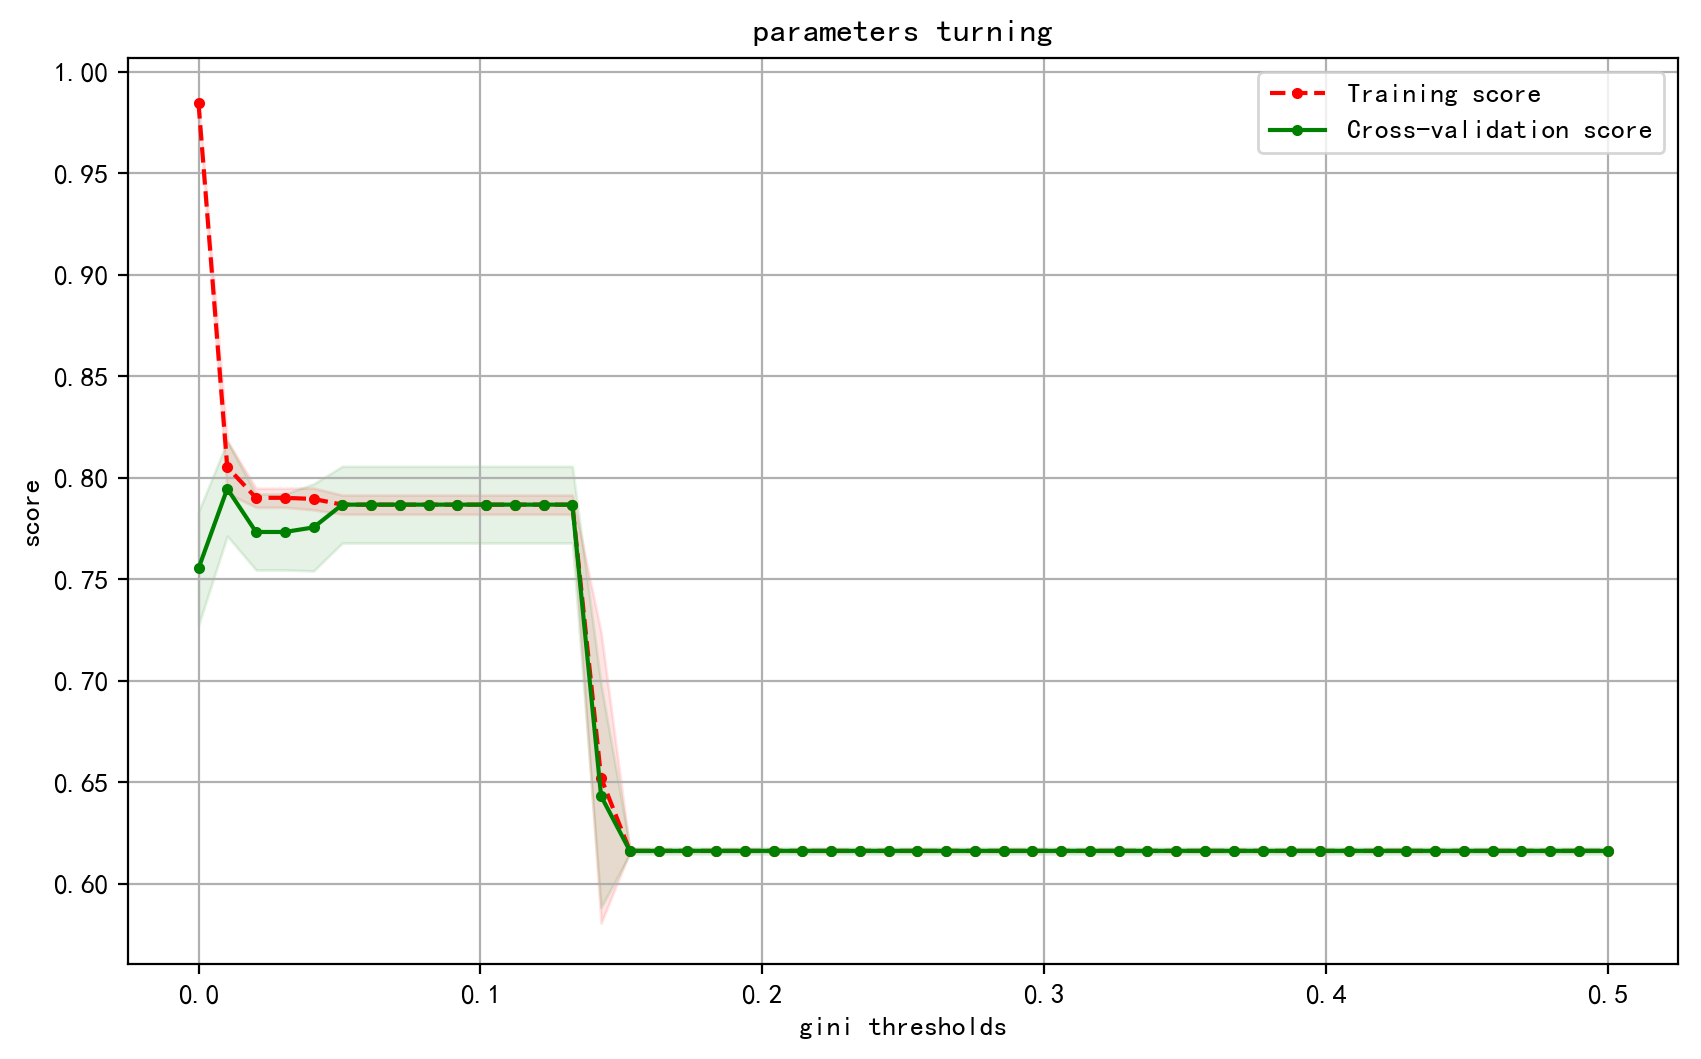

In [53]:
plot_curve(thresholds, clf.cv_results_, xlabel='gini thresholds')

## 应该综合各个参数做网格搜索

In [55]:
entropy_thresholds = np.linspace(0, 1, 50)
gini_thresholds = np.linspace(0, 0.5, 50)

In [56]:
# Set the parameters by cross-validation
param_grid = [{
    'criterion': ['entropy'],
    'min_impurity_decrease': entropy_thresholds
}, {
    'criterion': ['gini'],
    'min_impurity_decrease': gini_thresholds
}, {
    'max_depth': range(2, 10)
}, {
    'min_impurity_decrease': range(2, 30, 2)
}]
param_grid

[{'criterion': ['entropy'],
  'min_impurity_decrease': array([0.        , 0.02040816, 0.04081633, 0.06122449, 0.08163265,
         0.10204082, 0.12244898, 0.14285714, 0.16326531, 0.18367347,
         0.20408163, 0.2244898 , 0.24489796, 0.26530612, 0.28571429,
         0.30612245, 0.32653061, 0.34693878, 0.36734694, 0.3877551 ,
         0.40816327, 0.42857143, 0.44897959, 0.46938776, 0.48979592,
         0.51020408, 0.53061224, 0.55102041, 0.57142857, 0.59183673,
         0.6122449 , 0.63265306, 0.65306122, 0.67346939, 0.69387755,
         0.71428571, 0.73469388, 0.75510204, 0.7755102 , 0.79591837,
         0.81632653, 0.83673469, 0.85714286, 0.87755102, 0.89795918,
         0.91836735, 0.93877551, 0.95918367, 0.97959184, 1.        ])},
 {'criterion': ['gini'],
  'min_impurity_decrease': array([0.        , 0.01020408, 0.02040816, 0.03061224, 0.04081633,
         0.05102041, 0.06122449, 0.07142857, 0.08163265, 0.09183673,
         0.10204082, 0.1122449 , 0.12244898, 0.13265306, 0.1428571

In [58]:
clf = GridSearchCV(DecisionTreeClassifier(), param_grid, cv=5)
clf.fit(X, y)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid=[{'criterion': ['entropy'], 'min_impurity_decrease': array([0.     , 0.02041, 0.04082, 0.06122, 0.08163, 0.10204, 0.12245,
       0.14286, 0.16327, 0.18367, 0.20408, 0.22449, 0.2449 , 0.26531,
       0.28571, 0.30612, 0.32653, 0.34694, 0.36735, 0.38776, 0.40816,
       0.42857, 0.44898, 0...0.4898 ,
       0.5    ])}, {'max_depth': range(2, 10)}, {'min_impurity_decrease': range(2, 30, 2)}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [59]:
print("best param: {0}\nbest score: {1}".format(clf.best_params_,
                                                clf.best_score_))

best param: {'max_depth': 3}
best score: 0.8058361391694725


## 生成决策树图形

In [60]:
clf = DecisionTreeClassifier(max_depth=3)
clf.fit(X_train, y_train)
train_score = clf.score(X_train, y_train)
test_score = clf.score(X_test, y_test)
print('train score: {0}; test score: {1}'.format(train_score, test_score))

train score: 0.8146067415730337; test score: 0.7877094972067039


In [61]:
# 导出 titanic.dot 文件
with open("titanic.dot", 'w') as f:
    f = export_graphviz(clf, out_file=f)

# 1. 在电脑上安装 graphviz
# 2. 运行 `dot -Tpng titanic.dot -o titanic.png`
# 3. 在当前目录查看生成的决策树 titanic.png